In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from torch.distributions import normal
import matplotlib.pyplot as plt, numpy as np, pickle
from scipy.stats import norm
from tifffile import imread
import sys
sys.path.append('../')
#from pn2v import *
from lib.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel
from lib import histNoiseModel
from lib.utils import plotProbabilityDistribution
import os
import urllib
import zipfile
from pathlib import Path

Found 30 files.
(30, 1416, 1416)
(30, 1416, 1416)


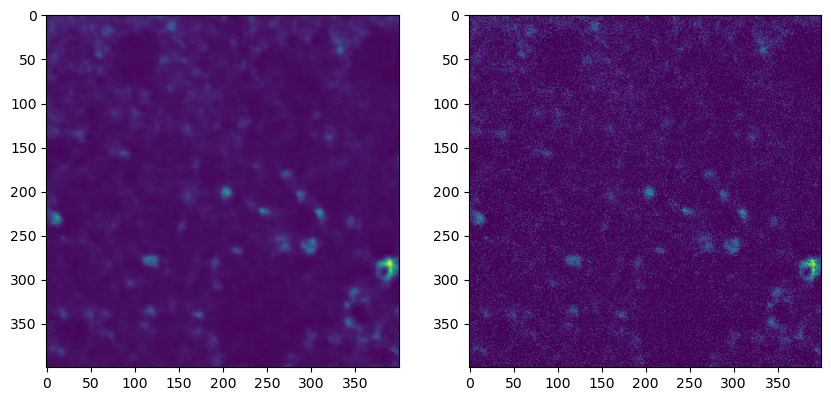

In [2]:
data_path_signal = Path(r"E:\dl_monalisa\n2v_results\Actin\Actin_fixed_3SNR_30nm_Middle_mse_1000epochs")
data_path_obs = Path(r"E:\dl_monalisa\n2v_results\Actin\Actin_fixed_3SNR_30nm_Middle_mse_1000epochs")
signal = []
observation = []

filters = ['tif','tiff']

files_signal = os.listdir(data_path_signal)
files_obs = os.listdir(data_path_obs)

#print(files)
assert len(files_obs) == len(files_signal)
print(f"Found {len(files_signal)} files.")
for i in range (len(files_obs)):
    file_signal = files_signal [i]
    file_obs = files_obs [i]

    if file_signal.split('.')[-1] not in filters:
        print(f"skipping {file_signal} because not in filters")
        continue
    
    im_signal = imread(data_path_signal / file_signal)[1]
    im_obs  = imread(data_path_obs / file_obs)[0]

    observation.append(im_obs)
    sig = im_signal
    sig[sig<0] = 0
    signal.append(sig)

signal = np.stack(signal)
observation = np.stack(observation)

plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(signal[0][400:800,400:800])

plt.subplot(1,2,2)
plt.imshow(observation[0][400:800,400:800])

print(signal.shape)
print(observation.shape)

In [3]:
dataName = 'Middle' # Name of the noise model 
n_gaussian = 3 # Number of gaussians to use for Gaussian Mixture Model
n_coeff = 2 # No. of polynomial coefficients for parameterizing the mean, standard deviation and weight of Gaussian components.

In [4]:
min_signal = np.min(signal)
max_signal = np.max(signal)
print(min_signal,max_signal)

min_obs = np.min(observation)
max_obs = np.max(observation)
print(min_obs,max_obs)

0.0 3545.962
0.0 3911.5806


In [14]:
# We set the range of values we want to cover with our model.
# The pixel intensities in the images you want to denoise have to lie within this range.
# The dataset is clipped to values between 0 and 255.
minVal, maxVal = 0, 4000
bins = 256

# We are creating the histogram.
# This can take a minute.
histogram = histNoiseModel.createHistogram(bins, minVal, maxVal, observation,signal)

# Saving histogram to disc.

nameHistNoiseModel = 'HistNoiseModel_'+str(dataName)+'_'+'calibration'
save_path = r"E:\dl_monalisa\n2v_results\Actin\noise_models\\" + nameHistNoiseModel
np.save(save_path, histogram)
print(f"Saved at {save_path}")
histogramFD=histogram[0]

Saved at E:\dl_monalisa\n2v_results\Actin\noise_models\\HistNoiseModel_Middle_calibration


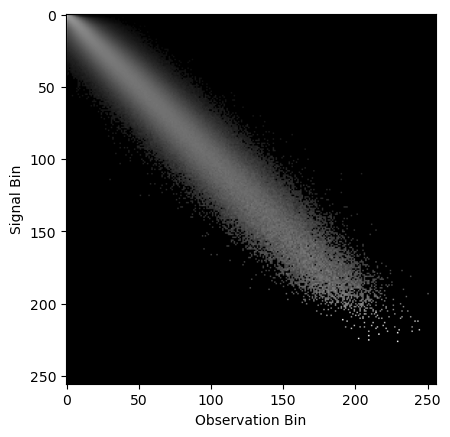

In [15]:
# Let's look at the histogram-based noise model.
plt.xlabel('Observation Bin')
plt.ylabel('Signal Bin')
plt.imshow(histogramFD**0.25, cmap='gray')
plt.show()

In [16]:
min_signal=np.min(signal)
max_signal=np.max(signal)
print("Minimum Signal Intensity is", min_signal)
print("Maximum Signal Intensity is", max_signal)

Minimum Signal Intensity is 0.0
Maximum Signal Intensity is 3545.962


In [17]:
gaussianMixtureNoiseModel = GaussianMixtureNoiseModel(min_signal = min_signal,
                                                    max_signal =max_signal,
                                                    path=str(save_path), weight = None, 
                                                    n_gaussian = n_gaussian,
                                                    n_coeff = n_coeff,
                                                    min_sigma = 50, 
                                                    device = device)

In [18]:
nameGMMNoiseModel = 'GMMNoiseModel_'+dataName+'_'+str(n_gaussian)+'_'+str(n_coeff)+'_'+'calibration'
print(nameGMMNoiseModel)

GMMNoiseModel_Middle_3_2_calibration


In [19]:
gaussianMixtureNoiseModel.train(signal, observation, batchSize = 250000, n_epochs = 2000, learning_rate=0.01, name = nameGMMNoiseModel)

0 9.811046600341797
100 6.973087787628174
200 5.287423610687256
300 5.040489673614502
400 4.9752726554870605
500 4.956220626831055
600 4.939601421356201
700 4.931102275848389
800 4.913744926452637
900 4.895675182342529
1000 4.887518882751465
1100 4.870611667633057
1200 4.865815162658691
1300 4.85784387588501
1400 4.852211952209473
1500 4.8475565910339355
1600 4.845130920410156
1700 4.84245491027832
1800 4.83633279800415
1900 4.836915969848633

The trained parameters (GMMNoiseModel_Middle_3_2_calibration) is saved at location: E:\dl_monalisa\n2v_results\Actin\noise_models\\HistNoiseModel_Middle_calibration
